# ***Mini projet SPARK***

Authors:
- Jean-Baptiste GOMEZ
- Yann SASSE
***
<center>

**Consommation de carburants en France**
**Mag 3 - 2023-2024**

</center>

## Importation des bibliothèques requises

In [3]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=d8778ef6f8b0debb76a87cc1699b681003bee4f1c7ae32558778692ff9fce9e1
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [4]:
## Démarrer une session spark en établissant la communication entre Python et Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Spark Gomez').getOrCreate()
spark

## ***Préparation des données - étape 1***

Avec PySpark :

- Lire et fusionner tous les fichiers de carburants
- Date fractionnée en année, mois, semaine de l'année
- Rendre les données disponibles sous forme de tableau afin de pouvoir utiliser Spark SQL
Grâce à des statistiques de base, déterminez quels types de carburants présentent un certain intérêt pour la suite du projet. Deux d’entre eux présentent peu d’intérêt et pourront être filtrés pour la suite du projet.

## Chargement des données

In [5]:
prix_2021 = spark.read.csv("Prix2021.csv.gz", sep=';', header=None, inferSchema=True)
prix_2022S1 = spark.read.csv("Prix2022S1.csv.gz", sep=';', header=None, inferSchema=True)
prix_2022S2 = spark.read.csv("Prix2022S2.csv.gz", sep=';', header=None, inferSchema=True)
prix_2023 = spark.read.csv("Prix2023.csv.gz", sep=';', header=None, inferSchema=True)

In [6]:
station_2023 = spark.read.option("encoding", "UTF-8").csv("Stations2023.csv.gz", sep='|', header=None, inferSchema=True)
service_2023 = spark.read.csv("Services2023.csv.gz", sep='|', header=None, inferSchema=True)

In [7]:
# Rename columns
prix_names = ['id_pdv', 'cp', 'pop', 'lat', 'long', 'date', 'gas_id', 'gas_type', 'price']
prix_2021 = prix_2021.toDF(*prix_names)
prix_2022S1 = prix_2022S1.toDF(*prix_names)
prix_2022S2 = prix_2022S2.toDF(*prix_names)
prix_2023 = prix_2023.toDF(*prix_names)

station_names = ['id_pdv', 'cp', 'pop', 'lat', 'long', 'address', 'city']
service_names = ['id_pdv', 'cp', 'pop', 'lat', 'long', 'services']

station_2023 = station_2023.toDF(*station_names)
service_2023 = service_2023.toDF(*service_names)
# Show the resulting DataFrame
prix_2023.show(5,truncate=False)

+-------+----+---+---------+--------+-------------------+------+--------+-----+
|id_pdv |cp  |pop|lat      |long    |date               |gas_id|gas_type|price|
+-------+----+---+---------+--------+-------------------+------+--------+-----+
|1000001|1000|R  |4620100.0|519800.0|2023-01-02 07:53:26|1     |Gazole  |1.867|
|1000001|1000|R  |4620100.0|519800.0|2023-01-05 09:33:37|1     |Gazole  |1.877|
|1000001|1000|R  |4620100.0|519800.0|2023-01-09 14:51:49|1     |Gazole  |1.875|
|1000001|1000|R  |4620100.0|519800.0|2023-01-11 09:23:54|1     |Gazole  |1.859|
|1000001|1000|R  |4620100.0|519800.0|2023-01-13 09:07:40|1     |Gazole  |1.862|
+-------+----+---+---------+--------+-------------------+------+--------+-----+
only showing top 5 rows



In [9]:

def dimension_dataframes(dataframes):
    # Find the number of rows and columns
    num_rows = dataframes.count()
    num_columns = len(dataframes.columns)

    return (num_rows, num_columns)


(num_rows_2021, num_columns_2021) = dimension_dataframes(prix_2021)
(num_rows_2022S1, num_columns_2022S1) = dimension_dataframes(prix_2022S1)
(num_rows_2022S2, num_columns_2022S2) = dimension_dataframes(prix_2022S2)
(num_rows_2023, num_columns_2023) = dimension_dataframes(prix_2023)
(num_rows_stat_2023, num_columns_stat_2023) = dimension_dataframes(station_2023)
(num_rows_serv_2023, num_columns_serv_2023) = dimension_dataframes(service_2023)

# Display the "shape"
print("Dimension prix 2021:", (num_rows_2021, num_columns_2021))
print("Dimension prix 2022S1:", (num_rows_2022S1,num_columns_2022S1))
print("Dimension prix 2022S2:", (num_rows_2022S2,num_columns_2022S2))
print("Dimension prix 2023:", (num_rows_2023, num_columns_2023))
print("Dimension Station 2023:", (num_rows_stat_2023, num_columns_stat_2023))
print("Dimension Service 2023:", (num_rows_serv_2023, num_columns_serv_2023))

Dimension prix 2021: (4287387, 9)
Dimension prix 2022S1: (2630689, 9)
Dimension prix 2022S2: (2304432, 9)
Dimension prix 2023: (4687530, 9)
Dimension Station 2023: (13837, 7)
Dimension Service 2023: (13837, 6)


## Fusion de tous les fichiers de carburants

### Fusion des prix caburants

In [10]:
# Concatenate (bind rows) the DataFrames
prix_df = prix_2021.union(prix_2022S1).union(prix_2022S2).union(prix_2023)

print("Dimension fusion prix 2021-2022-2023:", dimension_dataframes(prix_df))
# Show the resulting DataFrame
prix_df = prix_df.drop("cp","pop", "lat", "long")
prix_df.show(5,truncate=False)

Dimension fusion prix 2021-2022-2023: (13910038, 9)
+-------+-------------------+------+--------+------+
|id_pdv |date               |gas_id|gas_type|price |
+-------+-------------------+------+--------+------+
|1000001|2021-01-02 15:13:25|1     |Gazole  |1252.0|
|1000001|2021-01-04 09:28:43|1     |Gazole  |1268.0|
|1000001|2021-01-06 09:29:19|1     |Gazole  |1268.0|
|1000001|2021-01-06 15:45:51|1     |Gazole  |1268.0|
|1000001|2021-01-07 09:44:40|1     |Gazole  |1273.0|
+-------+-------------------+------+--------+------+
only showing top 5 rows



### Fusion des prix avec station et service

In [11]:
df_station_serv = station_2023.drop("cp" , "pop", "lat", "long").join(service_2023, ["id_pdv"], how="left")
print("Dimension station - service 2023:", dimension_dataframes(df_station_serv))
df_station_serv.show(5,truncate = False)

Dimension station - service 2023: (13837, 8)
+-------+--------------------------+---------------------+----+---+-------------+-------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id_pdv |address                   |city                 |cp  |pop|lat          |long         |services                                                                                                                                                                                                                                                                                                                 |
+-------+--------------------------+---------------------+----+---+-------------+-------------+----------------------------------------

In [12]:
df = prix_df.join(df_station_serv,["id_pdv"], how="left")
print("Dimension fusion prix-station-service:", dimension_dataframes(df))
df.show(5,truncate=False)

Dimension fusion prix-station-service: (13910038, 12)
+-------+-------------------+------+--------+------+---------------------+---------------------+----+---+---------+--------+-------------------------------------------------------------------------------------------------------+
|id_pdv |date               |gas_id|gas_type|price |address              |city                 |cp  |pop|lat      |long    |services                                                                                               |
+-------+-------------------+------+--------+------+---------------------+---------------------+----+---+---------+--------+-------------------------------------------------------------------------------------------------------+
|1000001|2021-01-02 15:13:25|1     |Gazole  |1252.0|596 AVENUE DE TREVOUX|SAINT-DENIS-LèS-BOURG|1000|R  |4620100.0|519800.0|Station de gonflage,Vente de gaz domestique (Butane, Propane),DAB (Distributeur automatique de billets)|
|1000001|2021-01-04 09:28:43|1

## Date fractionnée en année, mois, semaine de l'année

In [13]:
from pyspark.sql.types import DateType
from datetime import datetime
from pyspark.sql.functions import weekofyear
from pyspark.sql.functions import unix_timestamp, weekofyear, col, to_date, expr, floor
from pyspark.sql.types import TimestampType

df = df.withColumn("date_only", col("date").substr(1, 10))
df.show(5,truncate=False)

+-------+-------------------+------+--------+------+---------------------+---------------------+----+---+---------+--------+-------------------------------------------------------------------------------------------------------+----------+
|id_pdv |date               |gas_id|gas_type|price |address              |city                 |cp  |pop|lat      |long    |services                                                                                               |date_only |
+-------+-------------------+------+--------+------+---------------------+---------------------+----+---+---------+--------+-------------------------------------------------------------------------------------------------------+----------+
|1000001|2021-01-02 15:13:25|1     |Gazole  |1252.0|596 AVENUE DE TREVOUX|SAINT-DENIS-LèS-BOURG|1000|R  |4620100.0|519800.0|Station de gonflage,Vente de gaz domestique (Butane, Propane),DAB (Distributeur automatique de billets)|2021-01-02|
|1000001|2021-01-04 09:28:43|1     |Gazo

In [14]:
df.dtypes

[('id_pdv', 'int'),
 ('date', 'timestamp'),
 ('gas_id', 'int'),
 ('gas_type', 'string'),
 ('price', 'double'),
 ('address', 'string'),
 ('city', 'string'),
 ('cp', 'int'),
 ('pop', 'string'),
 ('lat', 'double'),
 ('long', 'double'),
 ('services', 'string'),
 ('date_only', 'string')]

In [15]:
# Convertir la colonne de chaînes de caractères en format de date
df = df.withColumn("date2", to_date("date_only", "yyyy-MM-dd"))
min_date = df.selectExpr("min(date2)").collect()[0][0]
print("Minimum de la colonne date:", min_date)

Minimum de la colonne date: 2021-01-01


In [16]:
date_debut = "2021-01-01"



# Calculer la différence en jours entre chaque date et la date de début
df = df.withColumn("days_since_start", expr(f"datediff(date2, '{date_debut}')"))

# Calculer la semaine de l'année manuellement
df = df.withColumn("week_of_year_manual", floor(expr("(days_since_start / 7) + 1")))

df.show(5,truncate=False)

+-------+-------------------+------+--------+------+------------------+----------+----+---+-------------+-------------+--------+----------+----------+----------------+-------------------+
|id_pdv |date               |gas_id|gas_type|price |address           |city      |cp  |pop|lat          |long         |services|date_only |date2     |days_since_start|week_of_year_manual|
+-------+-------------------+------+--------+------+------------------+----------+----+---+-------------+-------------+--------+----------+----------+----------------+-------------------+
|1160005|2021-01-01 00:01:00|1     |Gazole  |1262.0|RTE DE BOURG RN 75|Pont-d'Ain|1160|R  |4605335.06156|533741.036717|NULL    |2021-01-01|2021-01-01|0               |1                  |
|1160005|2021-01-02 00:01:00|1     |Gazole  |1262.0|RTE DE BOURG RN 75|Pont-d'Ain|1160|R  |4605335.06156|533741.036717|NULL    |2021-01-02|2021-01-02|1               |1                  |
|1160005|2021-01-03 00:01:00|1     |Gazole  |1262.0|RTE DE B

In [17]:
import pyspark.sql.functions as F #col, year, month, weekofyear

# Split the date into year, month
df = df.withColumn("year", F.year(F.col("date")))
df = df.withColumn("month", F.month(F.col("date")))

df = df.selectExpr("id_pdv", "cp" , "pop", "lat", "long",
                    "date", "year", "month", "week_of_year_manual", "gas_id",
                    "gas_type", "price", "address", "city", "services")
df.show(5,truncate=False)

+-------+----+---+---------+--------+-------------------+----+-----+-------------------+------+--------+------+---------------------+---------------------+-------------------------------------------------------------------------------------------------------+
|id_pdv |cp  |pop|lat      |long    |date               |year|month|week_of_year_manual|gas_id|gas_type|price |address              |city                 |services                                                                                               |
+-------+----+---+---------+--------+-------------------+----+-----+-------------------+------+--------+------+---------------------+---------------------+-------------------------------------------------------------------------------------------------------+
|1000001|1000|R  |4620100.0|519800.0|2021-01-02 15:13:25|2021|1    |1                  |1     |Gazole  |1252.0|596 AVENUE DE TREVOUX|SAINT-DENIS-LèS-BOURG|Station de gonflage,Vente de gaz domestique (Butane, Propane),DAB

### Statistiques de base.

In [ ]:
df.describe().toPandas().set_index('summary').transpose()

summary,count,mean,stddev,min,max
id_pdv,13910038,5.179937708308755E7,2.6869798125143494E7,1000001,96600001
cp,13895163,51789.95842452514,26867.371431997424,1000,97429
pop,13895163,None,None,A,R
lat,13894960,4686800.420188068,225871.1187711849,-2094971.3596753,6260655.98007
long,13894963,261140.54648614695,273055.7903288592,-472300.0,5529526.0602666
year,13898160,2022.0287563965303,0.802726400748052,2021,2023
month,13898160,6.472393395960329,3.426742143982171,1,12
week_of_year_manual,13898160,79.92443978195675,44.311146795074045,1,157
gas_id,13898160,3.607764121293754,2.040891069974928,1,6
gas_type,13898160,None,None,E10,SP98


Déterminez quels types de carburants présentent un certain intérêt pour la suite du projet. Deux d’entre eux présentent peu d’intérêt et pourront être filtrés pour la suite du projet.

In [ ]:
#Valeurs distinctes de types de caburant
df.select("gas_type").distinct().show(truncate = False)

+--------+
|gas_type|
+--------+
|E10     |
|SP98    |
|E85     |
|Gazole  |
|SP95    |
|GPLc    |
|NULL    |
+--------+



Suppression de la ligne où `gas_type == NULL`

In [ ]:

df = df.filter(F.col("gas_type").isNotNull())
df.select("gas_type").distinct().show(truncate = False)

+--------+
|gas_type|
+--------+
|E10     |
|SP98    |
|E85     |
|Gazole  |
|SP95    |
|GPLc    |
+--------+



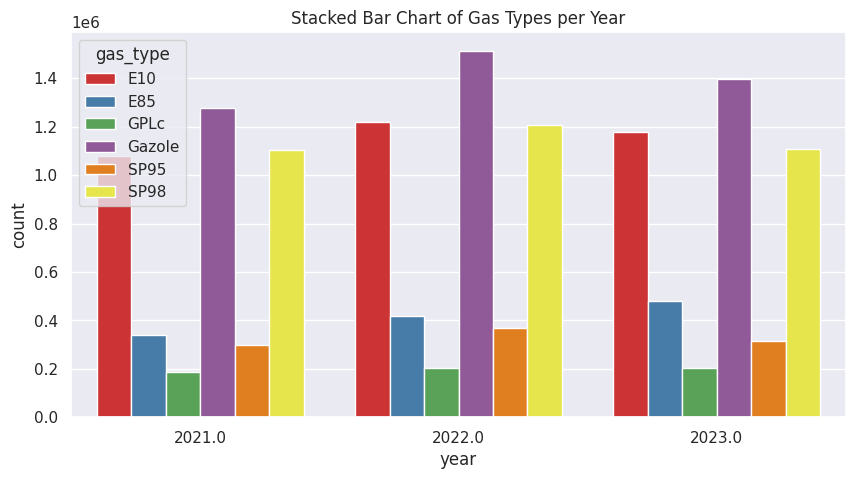

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

#df_years = df.withColumn("year", df["year"].cast("int"))

# Group by 'year' and 'gas_type' and count occurrences
count_df = df.groupBy('year', 'gas_type').agg(F.count('*').alias('count')).orderBy('year', 'gas_type')
#count_df.show()
# Convert PySpark DataFrame to Pandas DataFrame
count_pandas = count_df.toPandas()

# Create a stacked bar chart
plt.figure(figsize=(10, 5))
sns.barplot(x='year', y='count', hue='gas_type', data=count_pandas, palette='Set1', edgecolor='w')
plt.title('Stacked Bar Chart of Gas Types per Year')
plt.show()


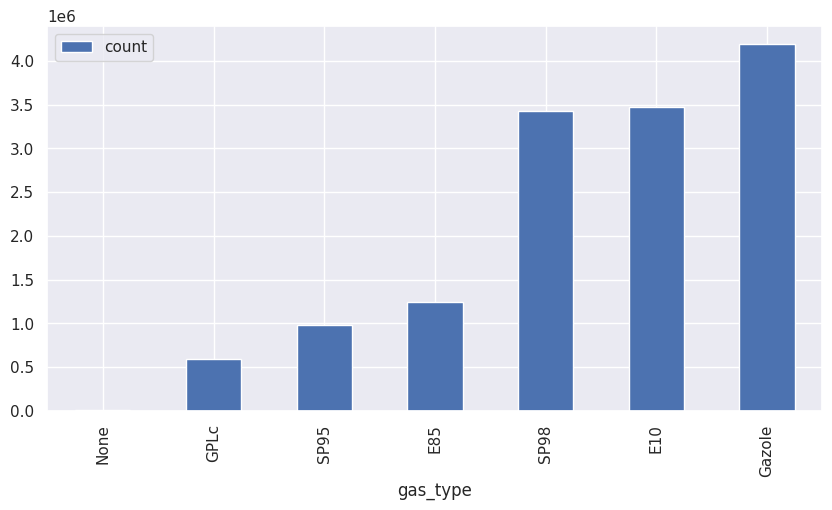

In [20]:
import seaborn as sns   # seaborn est une extension de matplotlib
sns.set()
(df
 .groupBy('gas_type')
 .agg(F.count('*').alias('count'))
 .orderBy('count')
 .toPandas()
).plot(kind='bar', x='gas_type', y='count', figsize=(10, 5));

Comme on peut le voir sur les deux graphiques précédentes les deux types de caburant qui ont peu d'intérêt sont ***GPLc*** et ***SP95***.

# ***Utilisation de Spark SQL***

Nous avons ensuite rendu les données disponibles sous forme de tableau temporaire afin de pouvoir utiliser Spark SQL.
Nom de la table : `Consommation_caburant`.

In [ ]:
df.createOrReplaceTempView("Consommation_caburant")

## ***Préparation des données - étape 2***

- Calculer l'indice des prix pour chaque station par semaine :
La formule étant :
$$
Price index = 100 * (\frac{Day Price in station - Average Day Price in France}{Average Day Price in France} + 1)
$$

Mais quand on rend au même dénominateur on a:
$$
Price index = 100 * (\frac{Day Price in station}{Average Day Price in France})
$$

In [ ]:
# one step
result_df = spark.sql("""
    SELECT
        gas_type,
        week_of_year_manual,
        100 * (SUM(price) / AVG(price)) AS Price_Index
    FROM
        Consommation_caburant
    GROUP BY
        gas_type,
        week_of_year_manual
    ORDER BY
        gas_type, week_of_year_manual
""")

# Show the final result
result_df.show(5,truncate=False)

+--------+-------------------+-----------+
|gas_type|week_of_year_manual|Price_Index|
+--------+-------------------+-----------+
|E10     |1                  |1854000.0  |
|E10     |2                  |2436000.0  |
|E10     |3                  |1896400.0  |
|E10     |4                  |1673800.0  |
|E10     |5                  |1820600.0  |
+--------+-------------------+-----------+
only showing top 5 rows



Calculer l'index de la semaine:
- Calculez une nouvelle variable appelée «Index de la semaine» pour chaque enregistrement en comptant le nombre de semaines depuis la première semaine du fichier.
- Exemple : si vous avez chargé les années 2019 à 2021, la première semaine de 2019 doit être numérotée 1, la dernière semaine de 2021 doit être numérotée 156 (3 x 52)
- Dans notre cas, l'index  de la semaine a été déjà calculé depuis le début de ce programme et correspond au colonne week_of_year_manual.
  

In [ ]:
from pyspark.sql.functions import first, last

# Obtenir la première valeur de la colonne week_of_year_manual
premiere_valeur = df.select(first('week_of_year_manual')).first()[0]

# Obtenir la dernière valeur de la colonne
derniere_valeur = df.select(last('week_of_year_manual')).first()[0]


print("La première valeur de la week_of_year_manual est :", premiere_valeur)
print("La dernière valeur de la week_of_year_manual est :", derniere_valeur)


La première valeur de la week_of_year_manual est : 1
La dernière valeur de la week_of_year_manual est : 157


## ***Visualisation des données***

En utilisant matplotlib/seaborn ou plotly :
Représenter l'évolution hebdomadaire du prix moyen des carburant sur la France tel que :

*   Le prix moyen de chaque type de carburant est représenté par une
ligne
*   Les coordonnées en X sont l'index précédemment calculé de la
semaine

* La coordonnée Y est le prix moyen du type de carburant en France
sur la semaine.

In [18]:
from pyspark.sql.functions import avg
# Prix moyen hebdomadaire pour chaque type de carburant
average_prices = df.groupBy("week_of_year_manual", "gas_type").agg(avg("price").alias("avg_price"))
# Données pour l'affichage avec Matplotlib
data = average_prices.toPandas()
average_prices.show(5, truncate=False)

+-------------------+--------+------------------+
|week_of_year_manual|gas_type|avg_price         |
+-------------------+--------+------------------+
|31                 |Gazole  |1450.38668773126  |
|3                  |SP98    |1504.087397758255 |
|5                  |SP95    |1437.4654498044329|
|64                 |SP98    |2.055427330768952 |
|51                 |Gazole  |1535.612867748144 |
+-------------------+--------+------------------+
only showing top 5 rows



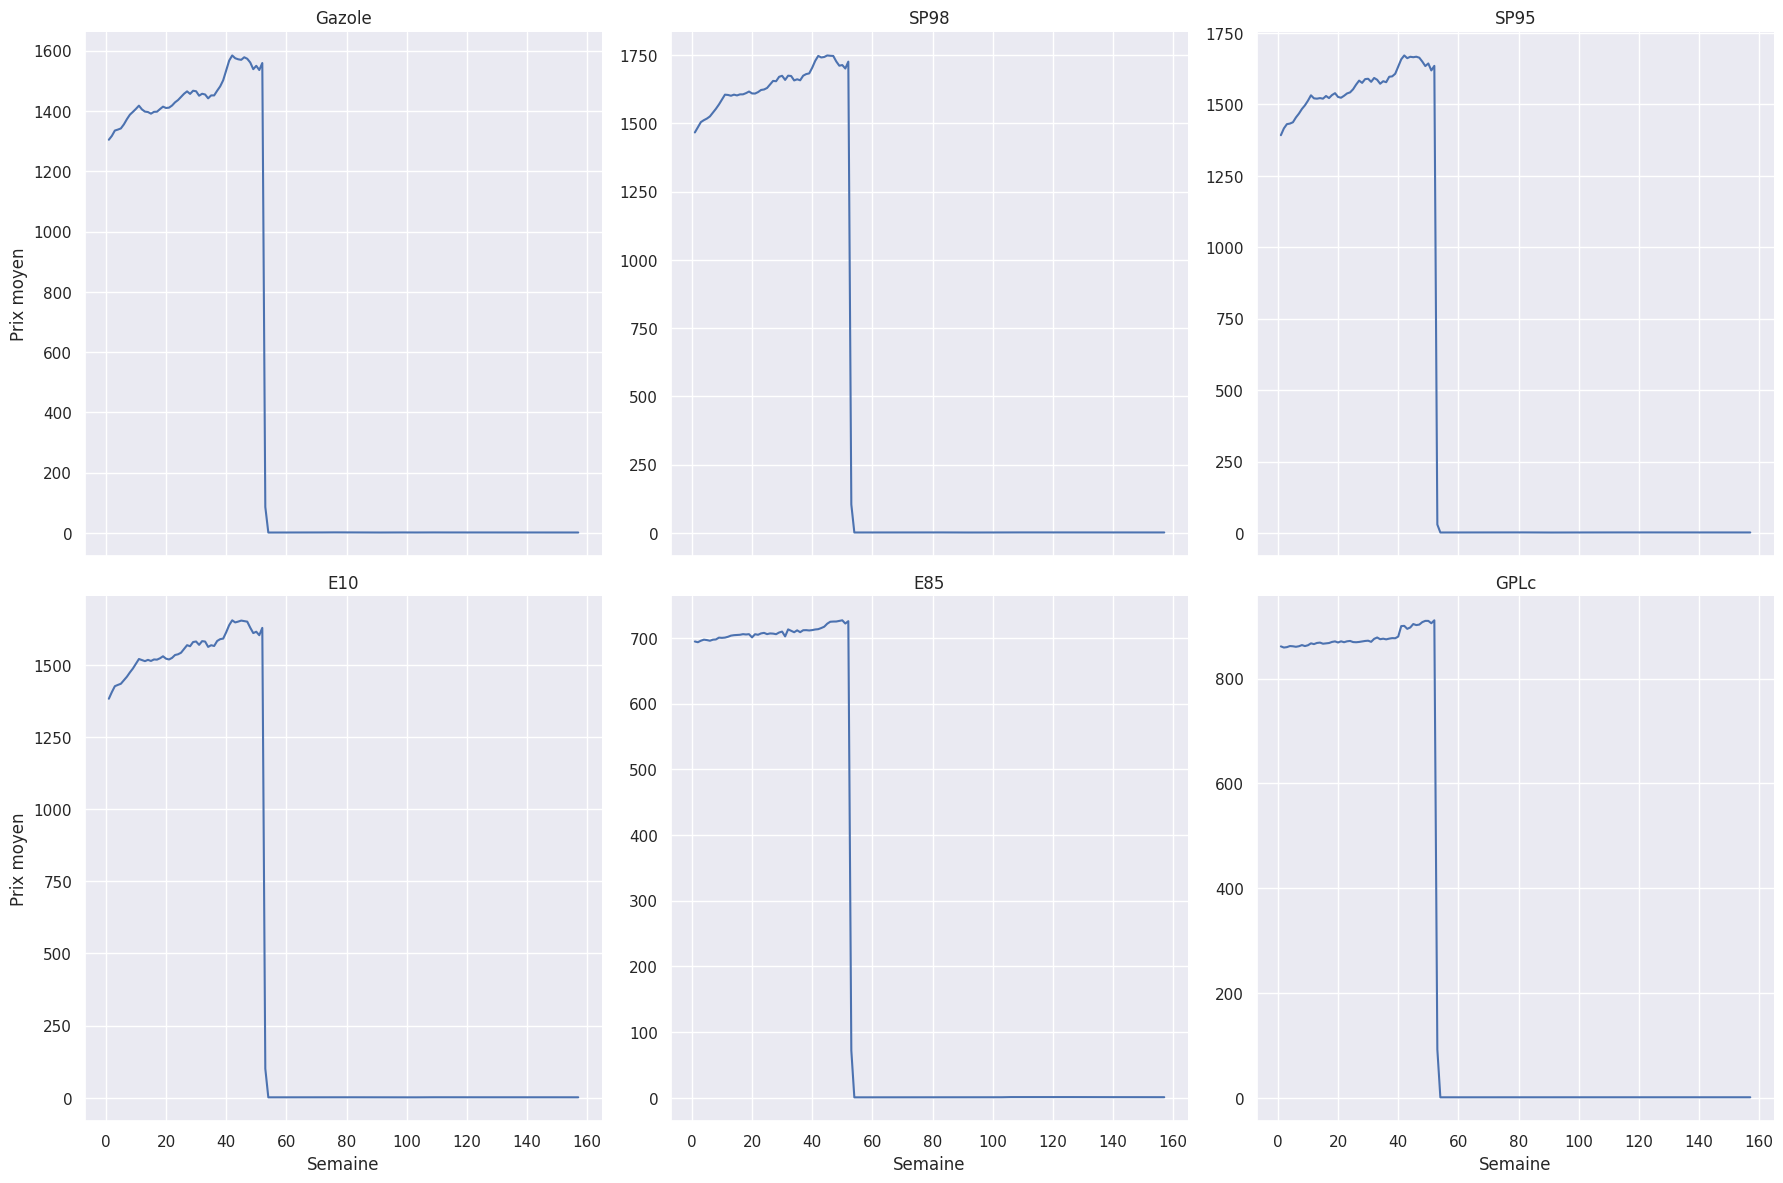

In [23]:
# Graphique à plusieurs lignes avec Seaborn FacetGrid
g = sns.FacetGrid(data, col="gas_type", col_wrap=3, height=6, sharey=False)
g.map(sns.lineplot, "week_of_year_manual", "avg_price")

g.set_axis_labels("Semaine", "Prix moyen")
g.set_titles(col_template="{col_name}")

plt.show()

###Représenter une carte avec le prix moyen pour chaque type de carburant de France par ville
• Pour cela, vous pouvez calculer le prix moyen agrégé par ville
pour un carburant que vous choisissez, pour une période donnée (une
année) et visualiser le résultat

## ***Modélisation – Prévision du prix le lendemain***
Construire un modèle basé sur Spark ML pour prévoir le prix du lendemain pour un type de carburant donné dans une station donnée

In [ ]:
df.show(5,truncate=False)

+-------+----+---+---------+--------+-------------------+----+-----+-------------------+------+--------+------+---------------------+---------------------+-------------------------------------------------------------------------------------------------------+
|id_pdv |cp  |pop|lat      |long    |date               |year|month|week_of_year_manual|gas_id|gas_type|price |address              |city                 |services                                                                                               |
+-------+----+---+---------+--------+-------------------+----+-----+-------------------+------+--------+------+---------------------+---------------------+-------------------------------------------------------------------------------------------------------+
|1000001|1000|R  |4620100.0|519800.0|2021-01-02 15:13:25|2021|1    |1                  |1     |Gazole  |1252.0|596 AVENUE DE TREVOUX|SAINT-DENIS-LèS-BOURG|Station de gonflage,Vente de gaz domestique (Butane, Propane),DAB

Pour effectuer la prediction du lendemain qui est une date sans heure on a besoin de récupérer la date sans l'heure à partir de la variable date.

Pour eviter le problème de multicolinérité parfaite entre date, date_only, year, month et week_of_year  ont va supprimer toutes ses colonnes et ne garder que date_only. On suggère aussi un problème de multicolinéarité entre address et services et le code postal (CP) donc on va garder que le code postal
le prix du lendemain pour un type de carburant donné dans une station donnée en fonctions de ses caractéristiques:
- ~~id_pdv~~
- ~~date~~
- ~~address~~
- ~~services~~
- ~~gas_id~~
- CP ✅ (Encodage Onehot)
- lat ✅
- long ✅
- year ✅ (Encodage Onehot)
- month ✅ (Encodage Onehot)
- week_of_year_manual ✅ (Encodage Onehot)
- pop ✅ (encodage Ordinale 0/1)
- price ✅
- ~~city~~
- gas_type ✅ (Encodage Onehot)

In [ ]:
df = df.selectExpr("cp", "pop", "lat", "long","year", "month","week_of_year_manual",
                    "gas_type", "price")
df.show(5,truncate=False)

+----+---+---------+--------+----+-----+-------------------+--------+------+
|cp  |pop|lat      |long    |year|month|week_of_year_manual|gas_type|price |
+----+---+---------+--------+----+-----+-------------------+--------+------+
|1000|R  |4620100.0|519800.0|2021|1    |1                  |Gazole  |1252.0|
|1000|R  |4620100.0|519800.0|2021|1    |1                  |Gazole  |1268.0|
|1000|R  |4620100.0|519800.0|2021|1    |1                  |Gazole  |1268.0|
|1000|R  |4620100.0|519800.0|2021|1    |1                  |Gazole  |1268.0|
|1000|R  |4620100.0|519800.0|2021|1    |1                  |Gazole  |1273.0|
+----+---+---------+--------+----+-----+-------------------+--------+------+
only showing top 5 rows



Type des variables

In [ ]:
df.printSchema()

root
 |-- cp: integer (nullable = true)
 |-- pop: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- week_of_year_manual: long (nullable = true)
 |-- gas_type: string (nullable = true)
 |-- price: double (nullable = true)



In [ ]:
# Liste des noms de colonnes à convertir en chaînes de caractères
columns_to_convert = ["year", "month", "week_of_year_manual"]

# Convertir chaque colonne en chaîne de caractères
for column in columns_to_convert:
  df = df.withColumn(column, F.col(column).cast(F.StringType()))

In [ ]:
df.printSchema()

root
 |-- cp: integer (nullable = true)
 |-- pop: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- week_of_year_manual: string (nullable = true)
 |-- gas_type: string (nullable = true)
 |-- price: double (nullable = true)



In [ ]:
df.select("pop").distinct().show(truncate = False)

+----+
|pop |
+----+
|A   |
|R   |
|NULL|
+----+



In [ ]:
df.select("gas_type").distinct().show(truncate = False)

+--------+
|gas_type|
+--------+
|E10     |
|SP98    |
|E85     |
|Gazole  |
|SP95    |
|GPLc    |
+--------+



In [ ]:
distinct_count = df.select("cp").distinct().count()

# Afficher le résultat
print("Nombre de valeurs distinctes dans la colonne 'cp':", distinct_count)

Nombre de valeurs distinctes dans la colonne 'cp': 4337


In [ ]:
df = df.withColumn("cp", F.col("cp").cast(F.StringType()))

Suppression de la valeur NULL dans toutes nos variables de type chaîne de caractère

In [ ]:
df = df.filter(F.col("pop").isNotNull())
df = df.filter(F.col("year").isNotNull())
df = df.filter(F.col("month").isNotNull())
df = df.filter(F.col("week_of_year_manual").isNotNull())
df = df.filter(F.col("cp").isNotNull())

### Encodage

Population : binaire (A,R)

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
# 1ère étape, transformation chaîne de caractères -> valeur numérique

# Phase de fit()
# Passage des chaînes de caractères en numérique, automatiquement (R -> 0, A -> 1)
npop = StringIndexer(inputCol='pop', outputCol='npop')
npop_encoder = npop.fit(df)

# Phase de transform()
npop_encoder.transform(df).select('cp', 'pop', 'npop').show(5)

+----+---+----+
|  cp|pop|npop|
+----+---+----+
|1160|  R| 0.0|
|1160|  R| 0.0|
|1160|  R| 0.0|
|1160|  R| 0.0|
|1160|  R| 0.0|
+----+---+----+
only showing top 5 rows



Type de Caburant - Gas_type (E10, SP98, E85, Gazole, SP95 GPLc) - One Hot encoding

Le OneHotEncoder utilise un codage "creux" (_sparse_) pour le vecteur `ohe_gas_type`.

Codage sparse, c'est un triplet :
* la dimension (nombre de valeur, ici 6)
* la liste des positions des valeurs != 0)
* les valeurs elles-mêmes

Par exemple : `(6, [0], [1.0])` se lit "il y a 6 dimensions au vecteur, et il y a une valeur non nulle en position [0], et cette valeur non nulle vaut 1.

* Gazole -> 1 0 0 0 0 0-> (6, 0, 1) : 6=dimension, 0=position du 1, 1=valeur à la position
* SP98   -> 0 1 0 0 0 0-> (6, 1, 1)
* E85    -> 0 0 1 0 0 0 -> (6, 2, 1)


Pensez au cas avec 100 modalités (exemple) :
* xx -> 00000000....1.....0000 = 100 chiffres en codage _dense_
* xx -> (100, 53, 1) = 3 chiffres en codage _sparse_

In [ ]:
# 1ère étape, transformation chaîne de caractères -> valeur numérique

# Phase de fit()
# Passage des chaînes de caractères en numérique, automatiquement (Gazole -> 0, SP98 -> 1, E85 -> 2, etc)
ngas_type = StringIndexer(inputCol='gas_type', outputCol='ngas_type')
ngas_type_encoder = ngas_type.fit(df)

# Phase de transform()
ngas_type_encoder.transform(df).select('cp', 'gas_type', 'ngas_type').show(5)
# 2ième étape, encodage en variables binaires
ohegas_type = OneHotEncoder(inputCol='ngas_type', outputCol='ohe_gas_type', dropLast=False)
ohegas_type_encoder = ohegas_type.fit(ngas_type_encoder.transform(df))

ohegas_type_encoder.transform(ngas_type_encoder.transform(df)).select('cp', 'gas_type', 'ngas_type', 'ohe_gas_type').show(5)

+----+--------+---------+
|  cp|gas_type|ngas_type|
+----+--------+---------+
|1160|  Gazole|      0.0|
|1160|  Gazole|      0.0|
|1160|  Gazole|      0.0|
|1160|  Gazole|      0.0|
|1160|  Gazole|      0.0|
+----+--------+---------+
only showing top 5 rows

+----+--------+---------+-------------+
|  cp|gas_type|ngas_type| ohe_gas_type|
+----+--------+---------+-------------+
|1160|  Gazole|      0.0|(6,[0],[1.0])|
|1160|  Gazole|      0.0|(6,[0],[1.0])|
|1160|  Gazole|      0.0|(6,[0],[1.0])|
|1160|  Gazole|      0.0|(6,[0],[1.0])|
|1160|  Gazole|      0.0|(6,[0],[1.0])|
+----+--------+---------+-------------+
only showing top 5 rows



In [24]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Imputer, VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor

n_pop = StringIndexer(inputCol='pop', outputCol='npop')
n_gas_type = StringIndexer(inputCol='gas_type', outputCol='ngas_type')
ohe_gas_type = OneHotEncoder(inputCol='ngas_type', outputCol='ohegas_type')
n_year = StringIndexer(inputCol='year', outputCol='nyear')
ohe_year = OneHotEncoder(inputCol='nyear', outputCol='oheyear')
n_month = StringIndexer(inputCol='month', outputCol='nmonth')
ohe_month = OneHotEncoder(inputCol='nmonth', outputCol='ohemonth')
n_week_of_year_manual = StringIndexer(inputCol='week_of_year_manual', outputCol='nweek_of_year_manual')
ohe_week_of_year_manual = OneHotEncoder(inputCol='nweek_of_year_manual', outputCol='oheweek_of_year_manual')
n_cp = StringIndexer(inputCol='cp', outputCol='ncp')
ohe_cp= OneHotEncoder(inputCol='ncp', outputCol='ohecp')

features = VectorAssembler(inputCols=['lat', 'long', 'npop', 'ohecp','oheyear','ohemonth','oheweek_of_year_manual', 'ohegas_type'],
                           outputCol = 'features')# 8 vecteurs stockées dans la colonne features
pipeline = Pipeline(stages = [n_pop, n_cp, ohe_cp, n_year, ohe_year, n_month, ohe_month, n_week_of_year_manual, ohe_week_of_year_manual, n_gas_type, ohe_gas_type, features]) # on ne prend que les objets du StringIndexer

In [ ]:
pipeline.fit(df).transform(df).show(5, truncate=False)

+----+---+-------------+-------------+----+-----+-------------------+--------+------+----+-----+------------------+-----+---------+------+--------------+--------------------+----------------------+---------+-------------+-----------------------------------------------------------------------------+
|cp  |pop|lat          |long         |year|month|week_of_year_manual|gas_type|price |npop|ncp  |ohecp             |nyear|oheyear  |nmonth|ohemonth      |nweek_of_year_manual|oheweek_of_year_manual|ngas_type|ohegas_type  |features                                                                     |
+----+---+-------------+-------------+----+-----+-------------------+--------+------+----+-----+------------------+-----+---------+------+--------------+--------------------+----------------------+---------+-------------+-----------------------------------------------------------------------------+
|1160|R  |4605335.06156|533741.036717|2021|1    |1                  |Gazole  |1262.0|0.0 |886.0|(433

### Random Forest Regressor

In [ ]:
#initialisation du modèle
model_forest = RandomForestRegressor(labelCol='price')
#création du pipeline
pipeline_forest = Pipeline(stages = [pipeline, model_forest])

In [ ]:
train_df,test_df = df.dropna(subset=['gas_type']).randomSplit([0.8,0.2], seed =1234)

In [ ]:
model_rf = pipeline_forest.fit(train_df)

In [ ]:
predictions_rf = model_rf.transform(test_df)

In [ ]:
predictions_rf.show(5)

+----+---+---------+--------+----+-----+-------------------+--------+------+----+-----+------------------+-----+---------+------+--------------+--------------------+----------------------+---------+-------------+--------------------+------------------+
|  cp|pop|      lat|    long|year|month|week_of_year_manual|gas_type| price|npop|  ncp|             ohecp|nyear|  oheyear|nmonth|      ohemonth|nweek_of_year_manual|oheweek_of_year_manual|ngas_type|  ohegas_type|            features|        prediction|
+----+---+---------+--------+----+-----+-------------------+--------+------+----+-----+------------------+-----+---------+------+--------------+--------------------+----------------------+---------+-------------+--------------------+------------------+
|1000|  R|4618800.0|524500.0|2021|    1|                  2|  Gazole|1420.0| 0.0|133.0|(4335,[133],[1.0])|  2.0|(2,[],[])|   4.0|(11,[4],[1.0])|                45.0|      (155,[45],[1.0])|      0.0|(5,[0],[1.0])|(4511,[0,1,136,43...|1305.845

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import expr

# Calculer RMSE
mse = predictions_rf.select(expr('POWER(price - prediction, 2)').alias('squared_error')).agg({'squared_error': 'mean'}).collect()[0][0]


In [ ]:
rmse = np.sqrt(mse)
print("RMSE pour random Forest:", rmse)

RMSE pour random Forest: 154.19894791071926


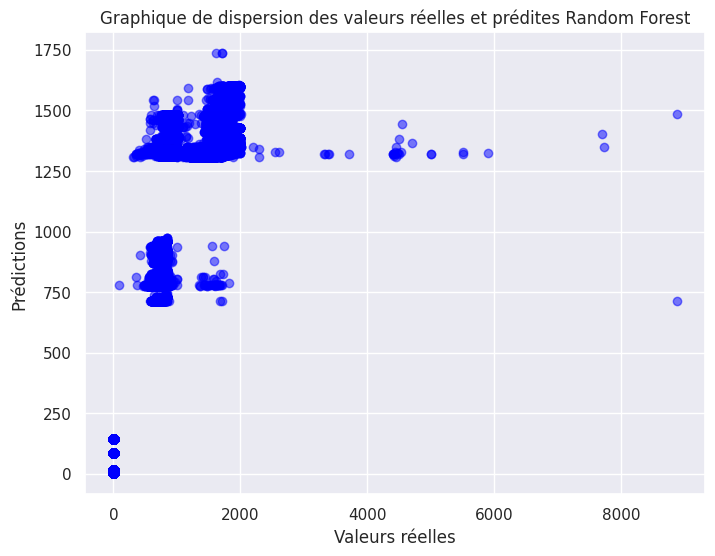

In [ ]:
# Tracer un graphique de dispersion
real_values = predictions_rf.select('price').rdd.map(lambda x: x[0]).collect()
predicted_values = predictions_rf.select('prediction').rdd.map(lambda x: x[0]).collect()

plt.figure(figsize=(8, 6))
plt.scatter(real_values, predicted_values, color='blue', alpha=0.5)
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Graphique de dispersion des valeurs réelles et prédites Random Forest')
plt.grid(True)
plt.show()

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions_rf)

print("Coefficient de détermination (R²) sur les données de test pour le random Forest = %g" % r2)

Coefficient de détermination (R²) sur les données de test pour le random Forest = 0.949593


### LinearRegression

In [25]:
#initialisation du modèle
model_lr = LinearRegression(labelCol='price')
#création du pipeline
pipeline_lr = Pipeline(stages = [pipeline, model_lr])

In [ ]:
model_lr = pipeline_lr.fit(train_df)

In [ ]:
predictions_lr = model_lr.transform(test_df)

In [ ]:
predictions_lr.show(5, truncate = False)

+----+---+---------+--------+----+-----+-------------------+--------+------+----+-----+------------------+-----+---------+------+--------------+--------------------+----------------------+---------+-------------+--------------------------------------------------------------------+------------------+
|cp  |pop|lat      |long    |year|month|week_of_year_manual|gas_type|price |npop|ncp  |ohecp             |nyear|oheyear  |nmonth|ohemonth      |nweek_of_year_manual|oheweek_of_year_manual|ngas_type|ohegas_type  |features                                                            |prediction        |
+----+---+---------+--------+----+-----+-------------------+--------+------+----+-----+------------------+-----+---------+------+--------------+--------------------+----------------------+---------+-------------+--------------------------------------------------------------------+------------------+
|1000|R  |4618800.0|524500.0|2021|1    |2                  |Gazole  |1420.0|0.0 |133.0|(4335,[133

In [ ]:
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions_lr)

print("Coefficient de détermination (R²) sur les données de test linear regression = %g" % r2)

Coefficient de détermination (R²) sur les données de test linear regression = 0.96405


In [ ]:
# Calculer RMSE
mse = predictions_lr.select(expr('POWER(price - prediction, 2)').alias('squared_error')).agg({'squared_error': 'mean'}).collect()[0][0]
rmse = np.sqrt(mse)
print("RMSE pour linear regression:", rmse)

RMSE pour linear regression: 130.22129821770017


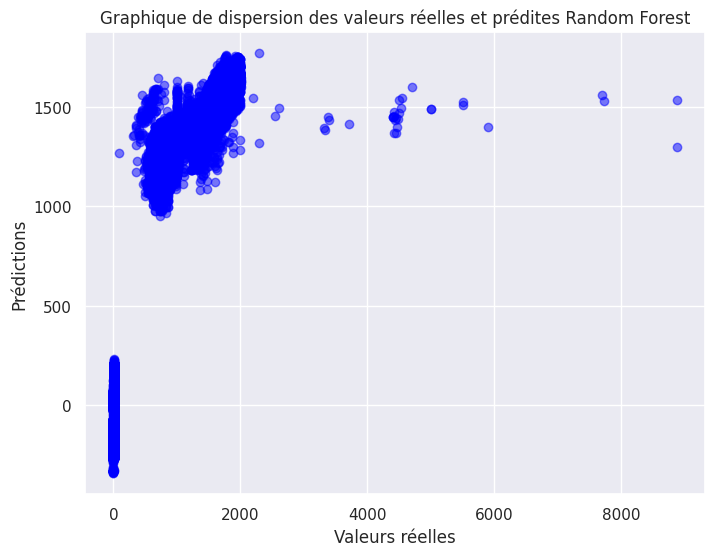

In [ ]:
# Tracer un graphique de dispersion
real_values = predictions_lr.select('price').rdd.map(lambda x: x[0]).collect()
predicted_values = predictions_lr.select('prediction').rdd.map(lambda x: x[0]).collect()

plt.figure(figsize=(8, 6))
plt.scatter(real_values, predicted_values, color='blue', alpha=0.5)
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Graphique de dispersion des valeurs réelles et prédites Random Forest')
plt.grid(True)
plt.show()

## Conclusion
On voit qu'il ya autant de dispersion entre la valeur réelle des prix et celle prédire pour le model de Random Forest que pour le model de regression linéaire et cela s'explique par les grosses valeures de RMSE obtenue (**154.19** et **130.22**). On en déduire que bien que le R2 soit élevé ce n'est pas pour autant un indicateur de performance fiable pour nos modèles de prédiction.